In [1]:
import pandas as pd
import numpy as np
import alphalens as al
import pymysql

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


from scipy.stats.mstats import winsorize


from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as sm



In [2]:
# 获取因子相关数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,close,turnover_rate,total_share from stock_basic'
Turnover_table=pd.read_sql(sql,conn)


In [3]:
##获取行业代码数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,industry_id from stock_industry'
industry_sheet=pd.read_sql(sql,conn)


# 获取行业ID与行业名称

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select industry_id,industry_name from sw_industry'
industry_name_sheet=pd.read_sql(sql,conn)

In [4]:
data_use=Turnover_table.set_index(["trade_date","ts_code"]).reset_index()
data_use=data_use.sort_values(by=['ts_code','trade_date'])
data_use["trade_date"] = pd.to_datetime(data_use["trade_date"])

industry_use=industry_sheet.set_index(["trade_date","ts_code"]).reset_index()
industry_use=industry_use.sort_values(by=['ts_code','trade_date'])
industry_use["trade_date"] = pd.to_datetime(industry_use["trade_date"])

industry_use_1=pd.merge(industry_use,industry_name_sheet,on=['industry_id'],how='left')

In [5]:
industry_use_1

,trade_date,ts_code,industry_id,industry_name
0,2007-01-04,000001.SZ,005013,金融服务
1,2007-01-05,000001.SZ,005013,金融服务
2,2007-01-08,000001.SZ,005013,金融服务
3,2007-01-09,000001.SZ,005013,金融服务
4,2007-01-10,000001.SZ,005013,金融服务
...,...,...,...,...
9776381,2013-12-25,900957.SH,005003,建筑建材
9776382,2013-12-26,900957.SH,005003,建筑建材
9776383,2013-12-27,900957.SH,005003,建筑建材
9776384,2013-12-30,900957.SH,005003,建筑建材


In [6]:
data_use

,trade_date,ts_code,close,turnover_rate,total_share
0,2007-01-04,000001.SZ,14.11,4.9105,194582.2149
1,2007-01-05,000001.SZ,13.06,3.8126,194582.2149
2,2007-01-08,000001.SZ,13.37,2.2536,194582.2149
3,2007-01-09,000001.SZ,13.80,3.4035,194582.2149
4,2007-01-10,000001.SZ,14.08,3.1743,194582.2149
...,...,...,...,...,...
9624108,2022-03-23,872925.BJ,16.65,0.7101,4860.0000
9624109,2022-03-24,872925.BJ,16.64,0.4609,4860.0000
9624110,2022-03-25,872925.BJ,16.59,0.3776,4860.0000
9624111,2022-03-28,872925.BJ,15.87,0.2963,4860.0000


In [7]:
industry_factor=pd.merge(industry_use_1,data_use,on=['ts_code','trade_date'],how='inner')
industry_factor_1=industry_factor[industry_factor['trade_date']=='2020-12-31']
industry_factor_2=industry_factor_1.groupby(['industry_name'])['turnover_rate'].mean()
industry_factor_2=pd.DataFrame(industry_factor_2)
industry_factor_2=industry_factor_2.reset_index()

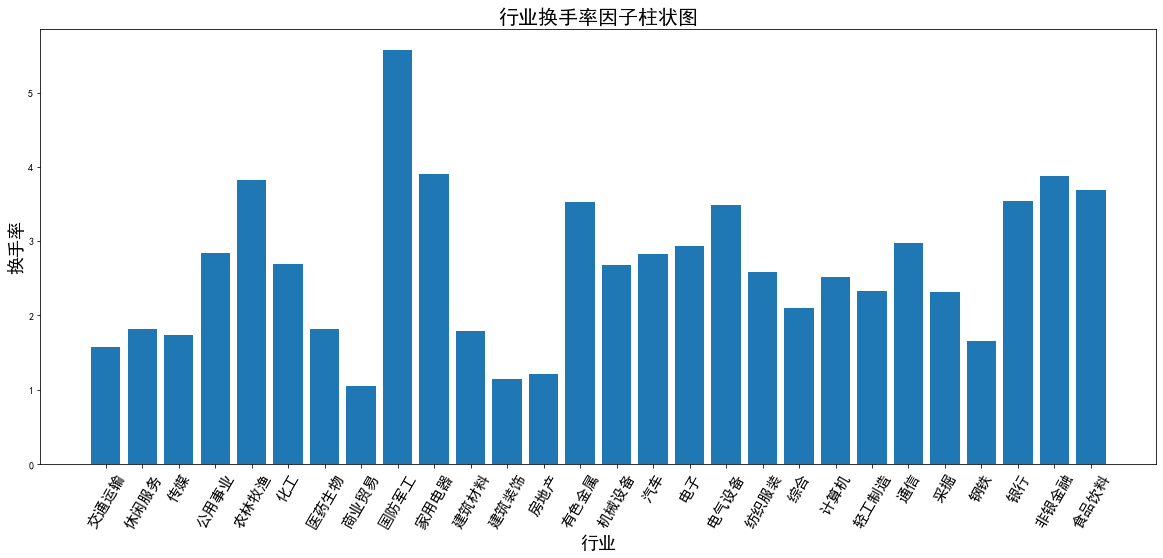

In [8]:
####行业换手率因子柱状图 (数据采纳2020.12.31各行业均值)

plt.figure(figsize=(20,8))
x=industry_factor_2['industry_name']
y=industry_factor_2['turnover_rate']
plt.bar(x,y)
plt.title('行业换手率因子柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('行业换手率因子柱状图.jpg')
plt.show()


In [9]:
# 行业因子排名表格，数据：2015-2020年最后一个交易日数据行业均值

industry_rank=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
industry_rank_1=industry_rank.groupby(['trade_date','industry_name'])['turnover_rate'].mean()
industry_rank_2=pd.DataFrame(industry_rank_1).reset_index()
industry_rank_2['年份']=industry_rank_2['trade_date'].dt.year
industry_rank_2=industry_rank_2.rename(columns={'industry_name':'行业'})
industry_rank_2['rank']=industry_rank_2.groupby(['年份'])['turnover_rate'].rank(ascending=False)
industry_rank_3=industry_rank_2.set_index(['行业','年份'])['rank'].unstack()
file='行业因子排名.xlsx'
industry_rank_3.to_excel(file)


In [10]:
industry_rank_3

年份,2015,2016,2017,2018,2019,2020
行业,,,,,,
交通运输,25.0,26.0,21.0,19.0,28.0,25.0
休闲服务,19.0,20.0,27.0,22.0,27.0,21.0
传媒,7.0,18.0,13.0,13.0,2.0,23.0
公用事业,24.0,27.0,11.0,17.0,26.0,11.0
农林牧渔,21.0,7.0,15.0,21.0,11.0,4.0
化工,9.0,10.0,6.0,10.0,8.0,13.0
医药生物,16.0,22.0,12.0,18.0,13.0,20.0
商业贸易,17.0,13.0,24.0,24.0,25.0,28.0
国防军工,27.0,12.0,9.0,5.0,16.0,1.0


In [11]:
# 因子按市值分层：1-5递增  数据为2015-2020年最后一个交易日数据

industry_factor['firm_size']=industry_factor['total_share']*industry_factor['close']
firm_size_group=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
firm_size_group_1=pd.DataFrame(firm_size_group.groupby(['trade_date','Group_ID'])['turnover_rate'].mean()).reset_index()
firm_size_group_1['year']=firm_size_group_1['trade_date'].dt.year




<ipython-input-11-54b984dc6aa6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))


<ipython-input-12-73ff45e0350c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))


NameError: name 'labels' is not defined

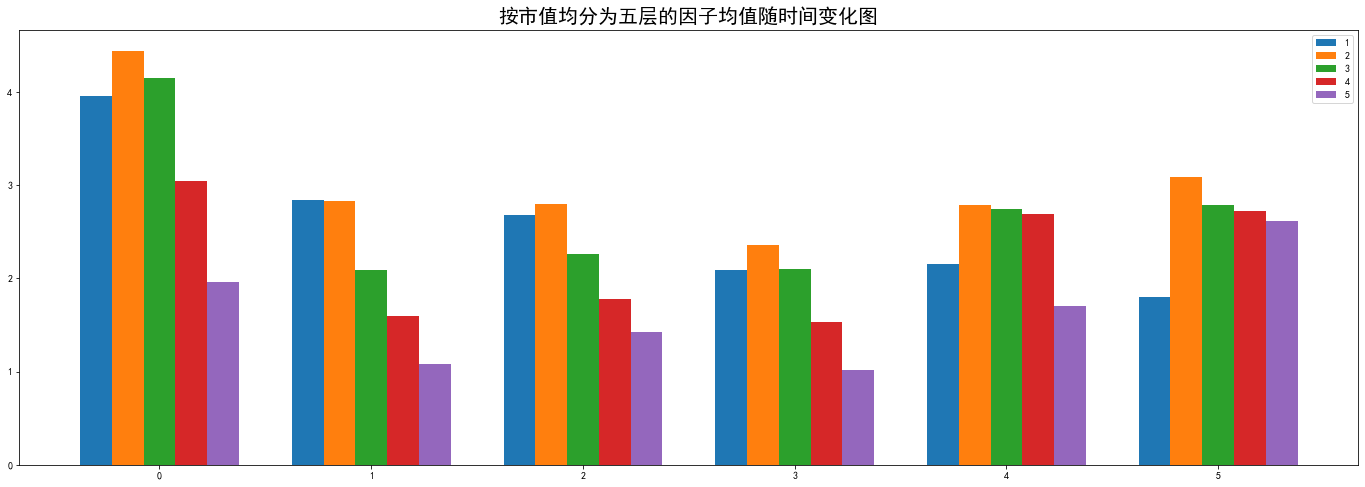

In [12]:


# 按市值均分为五层的因子均值随时间变化图 数据为2015-2020年最后一个交易日数据

# 因子按市值分层：1-5递增  数据为2015-2020年最后一个交易日数据

industry_factor['firm_size']=industry_factor['total_share']*industry_factor['close']
firm_size_group=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
firm_size_group_1=pd.DataFrame(firm_size_group.groupby(['trade_date','Group_ID'])['turnover_rate'].mean()).reset_index()
firm_size_group_1['year']=firm_size_group_1['trade_date'].dt.year


x=pd.Series(np.unique(firm_size_group_1['year']))
X=['2015','2016','2017','2018','2019','2020']
y1=firm_size_group_1[firm_size_group_1['Group_ID']=='1'].turnover_rate
y2=firm_size_group_1[firm_size_group_1['Group_ID']=='2'].turnover_rate
y3=firm_size_group_1[firm_size_group_1['Group_ID']=='3'].turnover_rate
y4=firm_size_group_1[firm_size_group_1['Group_ID']=='4'].turnover_rate
y5=firm_size_group_1[firm_size_group_1['Group_ID']=='5'].turnover_rate

width=0.15
pos=np.arange(len(x))

plt.figure(figsize=(24,8))
plt.bar(pos-2*width,y1,width,label='1')
plt.bar(pos-1*width,y2,width,label='2')
plt.bar(pos,y3,width,label='3')
plt.bar(pos+1*width,y4,width,label='4')
plt.bar(pos+2*width,y5,width,label='5')
# plt.grid()
plt.legend() # 图例
plt.title('按市值均分为五层的因子均值随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(pos,labels=labels,fontsize=15)
# plt.yticks(y,fontsize=15)
# # plt.ylim(0,6,1)
plt.xlabel('年份',fontsize=18)
plt.ylabel('换手率',fontsize=18)

plt.savefig('按市值均分为五层的因子均值随时间变化图.png')
plt.show()




In [13]:
# 因子与市值的相关系数变化:不分股票，一年所有数据进行corr计算 2015-2020

industry_factor['year']=industry_factor['trade_date'].dt.year
corr=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
corr_1=pd.DataFrame(corr.groupby(['year'])['turnover_rate'].corr(corr['firm_size'])).reset_index()
corr_1=corr_1.rename(columns={'turnover_rate':'corr'})

# 因子与市值的相关系数变化:不分股票，一个交易日所有数据进行corr计算
corr_2=pd.DataFrame(corr.groupby(['trade_date'])['turnover_rate'].corr(corr['firm_size'])).reset_index()
corr_2=corr_2.rename(columns={'turnover_rate':'corr'})

In [14]:
corr_1

,year,corr
0,2015,-0.088248
1,2016,-0.082793
2,2017,-0.060679
3,2018,-0.049113
4,2019,-0.052996
5,2020,-0.059865


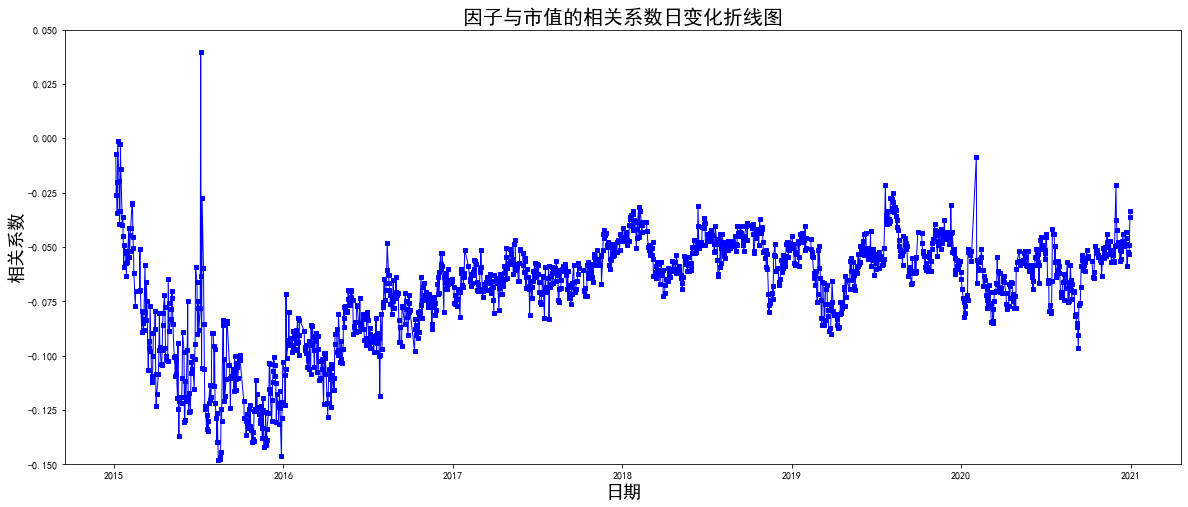

In [15]:
####因子与市值的相关系数日变化折线图  2015-2020

plt.figure(figsize=(20,8))
x=corr_2['trade_date']
y=corr_2['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='因子与市值的日相关系数')
plt.title('因子与市值的相关系数日变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(-0.15,0.05,0.05)
plt.xlabel('日期',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.savefig('因子与市值的相关系数日变化折线图.png')
plt.show()


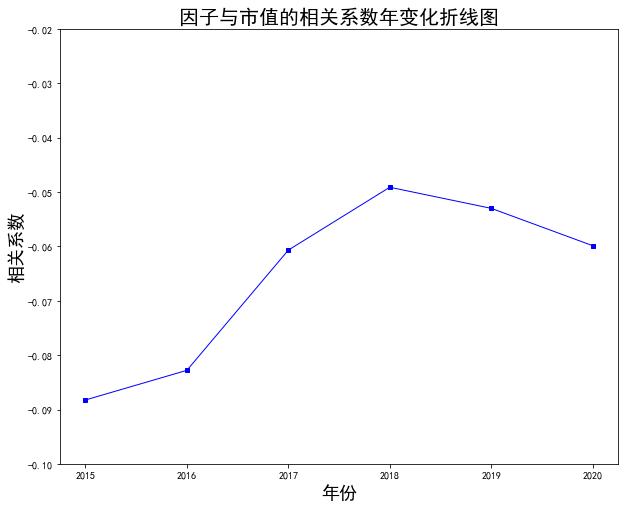

In [16]:
####因子与市值的相关系数年变化折线图  2015-2020

plt.figure(figsize=(10,8))
x=corr_1['year']
y=corr_1['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='因子与市值的年相关系数')
plt.title('因子与市值的相关系数年变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('年份',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.savefig('因子与市值的相关系数年变化折线图.png')

plt.show()




In [17]:
# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_turnover']=winsorize(industry_factor.turnover_rate,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

In [18]:
# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_turnover']=winsorize(industry_factor.turnover_rate,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_turnover'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_turnover':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_turnover']=neu_ind_2['win_turnover']-neu_ind_2['ind_mean']

In [19]:
neu_ind_2.sort_values(by=['trade_date','industry_name'])

,trade_date,industry_name,ind_mean,ts_code,industry_id,close,turnover_rate,total_share,firm_size,year,win_turnover,ind_neu_turnover
24237,2015-01-05,交通运输,2.676854,000022.SZ,011014,21.83,2.4565,64476.3730,1.407519e+06,2015,2.4565,-0.220354
74042,2015-01-05,交通运输,2.676854,000088.SZ,011014,10.07,2.2797,194220.0000,1.955795e+06,2015,2.2797,-0.397154
75498,2015-01-05,交通运输,2.676854,000089.SZ,011014,6.00,3.1869,169178.7662,1.015073e+06,2015,3.1869,0.510046
79870,2015-01-05,交通运输,2.676854,000099.SZ,011014,14.01,5.0301,60607.0420,8.491047e+05,2015,5.0301,2.353246
130002,2015-01-05,交通运输,2.676854,000429.SZ,011014,5.05,2.3550,125711.7748,6.348445e+05,2015,2.3550,-0.321854
...,...,...,...,...,...,...,...,...,...,...,...,...
4518994,2020-12-31,食品饮料,3.492630,603919.SH,011009,40.49,3.8260,50725.9997,2.053896e+06,2020,3.8260,0.333370
4561992,2020-12-31,食品饮料,3.492630,605179.SH,011009,17.66,7.1448,40100.0000,7.081660e+05,2020,7.1448,3.652170
4563079,2020-12-31,食品饮料,3.492630,605338.SH,011009,37.76,4.4800,24800.0000,9.364480e+05,2020,4.4800,0.987370
4563434,2020-12-31,食品饮料,3.492630,605388.SH,011009,22.38,15.0032,43000.0000,9.623400e+05,2020,14.0012,10.508570


In [20]:

# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_turnover']=winsorize(industry_factor.turnover_rate,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_turnover'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_turnover':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_turnover']=neu_ind_2['win_turnover']-neu_ind_2['ind_mean']

# 市值中性化（回归取残差）

def lr_resid(sdf):
    lr=LinearRegression().fit(sdf[['firm_size']],sdf['ind_neu_turnover'])
    return sdf['ind_neu_turnover']-lr.predict(sdf[['firm_size']])

# %%time
neu_ind_2['fz_ind_neu_turnover']=neu_ind_2.groupby("trade_date").apply(lr_resid).rename("fz_ind_neu_turnover").reset_index(level=0)['fz_ind_neu_turnover']

In [21]:
neu_ind_2

,trade_date,industry_name,ind_mean,ts_code,industry_id,close,turnover_rate,total_share,firm_size,year,win_turnover,ind_neu_turnover,fz_ind_neu_turnover
0,2015-01-05,银行,2.700550,000001.SZ,011018,16.02,2.9079,1.142489e+06,1.830268e+07,2015,2.9079,0.207350,0.354404
1,2015-01-06,银行,2.402213,000001.SZ,011018,15.78,2.2024,1.142489e+06,1.802848e+07,2015,2.2024,-0.199813,-0.044373
2,2015-01-07,银行,1.783650,000001.SZ,011018,15.48,1.7283,1.142489e+06,1.768574e+07,2015,1.7283,-0.055350,0.058430
3,2015-01-08,银行,1.596631,000001.SZ,011018,14.96,1.4311,1.142489e+06,1.709164e+07,2015,1.4311,-0.165531,-0.037447
4,2015-01-09,银行,2.566756,000001.SZ,011018,15.08,2.5501,1.142489e+06,1.722874e+07,2015,2.5501,-0.016656,0.066503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600793,2020-12-24,机械设备,2.693108,689009.SH,011024,73.10,12.7032,7.040917e+03,5.146910e+05,2020,12.7032,10.010092,9.969007
4600794,2020-12-25,机械设备,2.453421,689009.SH,011024,75.10,14.1817,7.040917e+03,5.287728e+05,2020,14.0012,11.547779,11.511882
4600795,2020-12-28,机械设备,2.678568,689009.SH,011024,80.10,14.0956,7.040917e+03,5.639774e+05,2020,14.0012,11.322632,11.287079
4600796,2020-12-30,机械设备,2.298881,689009.SH,011024,80.91,11.9446,7.040917e+03,5.696806e+05,2020,11.9446,9.645719,9.618366


In [22]:

# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_turnover']=winsorize(industry_factor.turnover_rate,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_turnover'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_turnover':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_turnover']=neu_ind_2['win_turnover']-neu_ind_2['ind_mean']

# 市值中性化（回归取残差）

def lr_resid(sdf):
    lr=LinearRegression().fit(sdf[['firm_size']],sdf['ind_neu_turnover'])
    return sdf['ind_neu_turnover']-lr.predict(sdf[['firm_size']])

# %%time
neu_ind_2['fz_ind_neu_turnover']=neu_ind_2.groupby("trade_date").apply(lr_resid).rename("fz_ind_neu_turnover").reset_index(level=0)['fz_ind_neu_turnover']


# 标准化：Z-score标准化，z=（个体观察值-当天总体数均值）/当天总体数据标准差

std_1=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_turnover'].mean()).reset_index().rename(columns={'fz_ind_neu_turnover':'date_mean'})
std_2=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_turnover'].std()).reset_index().rename(columns={'fz_ind_neu_turnover':'date_std'})
std_3=pd.merge(std_1,std_2,on=['trade_date'])
std_4=pd.merge(neu_ind_2,std_3,on=['trade_date'],how='left').sort_values(by=['trade_date','ts_code'])
std_4['std_neu_turnover']=(std_4['fz_ind_neu_turnover']-std_4['date_mean'])/std_4['date_std']



In [23]:
std_4

,trade_date,industry_name,ind_mean,ts_code,industry_id,close,turnover_rate,total_share,firm_size,year,win_turnover,ind_neu_turnover,fz_ind_neu_turnover,date_mean,date_std,std_neu_turnover
0,2015-01-05,银行,2.700550,000001.SZ,011018,16.02,2.9079,1.142489e+06,1.830268e+07,2015,2.9079,0.207350,0.354404,6.536872e-17,2.179449,0.162612
1462,2015-01-05,房地产,4.421861,000002.SZ,011015,14.91,6.7834,1.101503e+06,1.642341e+07,2015,6.7834,2.361539,2.491836,6.536872e-17,2.179449,1.143333
2789,2015-01-05,医药生物,2.289757,000004.SZ,011012,15.69,3.3496,8.397668e+03,1.317594e+05,2015,3.3496,1.059843,1.044877,6.536872e-17,2.179449,0.479422
5417,2015-01-05,房地产,4.421861,000006.SZ,011015,7.08,8.0562,1.349995e+05,9.557965e+05,2015,8.0562,3.634339,3.626720,6.536872e-17,2.179449,1.664054
6762,2015-01-05,休闲服务,3.036586,000007.SZ,011017,14.52,1.3807,2.309654e+04,3.353617e+05,2015,1.3807,-1.655886,-1.669036,6.536872e-17,2.179449,-0.765807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600598,2020-12-31,电子,2.888955,688699.SH,011006,55.17,11.4489,7.436800e+03,4.102883e+05,2020,11.4489,8.559945,8.525039,-1.669784e-16,2.690855,3.168152
4600625,2020-12-31,电气设备,3.274642,688777.SH,011023,100.20,5.5458,4.912900e+04,4.922726e+06,2020,5.5458,2.271158,2.329173,-1.669784e-16,2.690855,0.865588
4600676,2020-12-31,国防军工,4.908080,688788.SH,011025,133.30,8.1020,7.553423e+03,1.006871e+06,2020,8.1020,3.193920,3.171299,-1.669784e-16,2.690855,1.178547
4600791,2020-12-31,电子,2.888955,688981.SH,011006,57.75,4.5320,7.703506e+05,4.448775e+07,2020,4.5320,1.643045,2.515794,-1.669784e-16,2.690855,0.934942


In [24]:
# 整体结果做OLS回归，即因子值对下一个日期回报的进行回归

# 计算回报
ret_1=std_4.sort_values(by=['ts_code','trade_date']).set_index(['trade_date','ts_code'])
ret_2=ret_1['close'].unstack()
ret_3=(ret_2.shift(-1)-ret_2)/ret_2
ret_4=ret_3.stack().reset_index().rename(columns={0:'ret_t1'})
ret_5=pd.merge(ret_4,std_4,on=['trade_date','ts_code'],how='right')
# ret = ret_5.pivot(index = 'trade_date',columns = 'ts_code',values = 'close').pct_change(1).shift(-1).fillna(0)

# 做回归

OLS=sm.ols(formula="ret_t1~std_neu_turnover",data=ret_5).fit()
OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_t1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6860.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        05:45:26   Log-Likelihood:             9.0585e+06
No. Observations:             4587010   AIC:                        -1.812e+07
Df Residuals:                 4587008   BIC:                        -1.812e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0003   1.57e-05     18.484      0.000       0.000       0.000
std_neu_turnover    -0.0013   1.57e-05    -82.825      0.000      -0.001      -0.001
==============================================================================
Omnibus:                  1915039.765   Durbin-Watson:                   1.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        107644601.716
Skew:                          -1.224   Prob(JB):                         0.00
Kurtosis:                      26.606   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
OLS.bse

Intercept           0.000016
std_neu_turnover    0.000016
dtype: float64

In [106]:
def lr_t(sdf):
    t_series=sm.ols(formula="ret_t1~std_neu_turnover",data=sdf).fit()
    return t_series.bse





In [110]:
%%time
t_value=pd.DataFrame(ret_5.groupby("ts_code").apply(lr_t).reset_index(level=0))


IndexError: tuple index out of range

In [108]:
t_value

,trade_date,Intercept,std_neu_turnover
0,2015-01-05,0.000016,0.000016
1,2015-01-06,0.000016,0.000016
2,2015-01-07,0.000016,0.000016
3,2015-01-08,0.000016,0.000016
4,2015-01-09,0.000016,0.000016
...,...,...,...
1457,2020-12-25,0.000016,0.000016
1458,2020-12-28,0.000016,0.000016
1459,2020-12-29,0.000016,0.000016
1460,2020-12-30,0.000016,0.000016


In [27]:
# IC计算

# Normal IC
IC_1=pd.DataFrame(ret_5.groupby(['trade_date'])['std_neu_turnover'].corr(ret_5['ret_t1'])).reset_index()
IC_1=IC_1.rename(columns={'std_neu_turnover':'Normal_IC'})



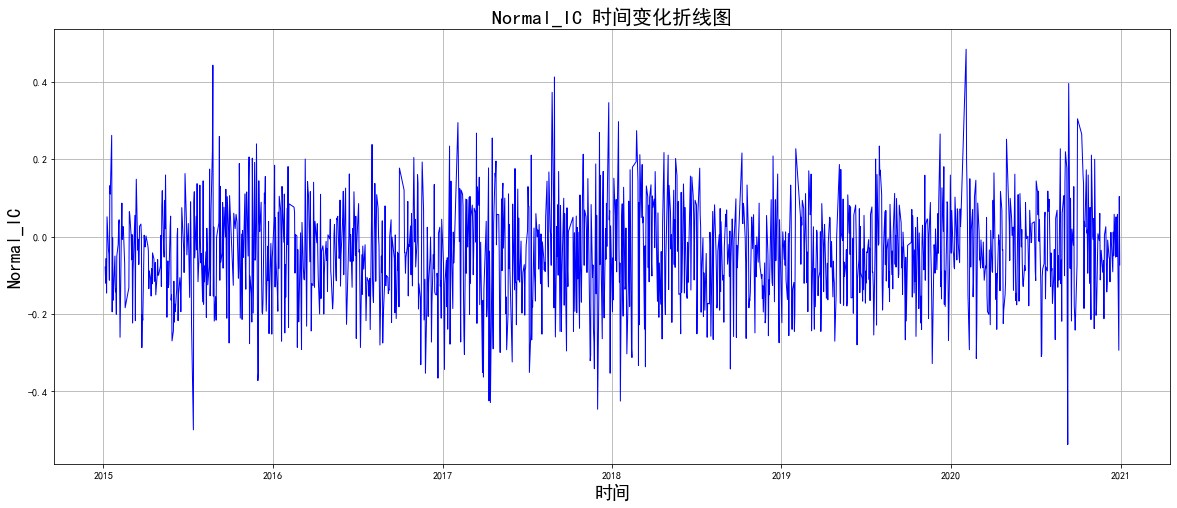

In [28]:
# Normal IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_1['trade_date']
y=IC_1['Normal_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='Normal_IC 时间变化折线图')
plt.title('Normal_IC 时间变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('Normal_IC',fontsize=18)
plt.grid()
plt.savefig('Normal_IC 时间变化折线图.png')
plt.show()




In [29]:
# rank IC 排序升序
IC_2=ret_5
IC_2['fac_rank']=IC_2.groupby(['trade_date'])['std_neu_turnover'].rank()
IC_3=pd.DataFrame(IC_2.groupby(['trade_date'])['fac_rank'].corr(IC_2['ret_t1'])).reset_index()
IC_3=IC_3.rename(columns={'fac_rank':'rank_IC'})


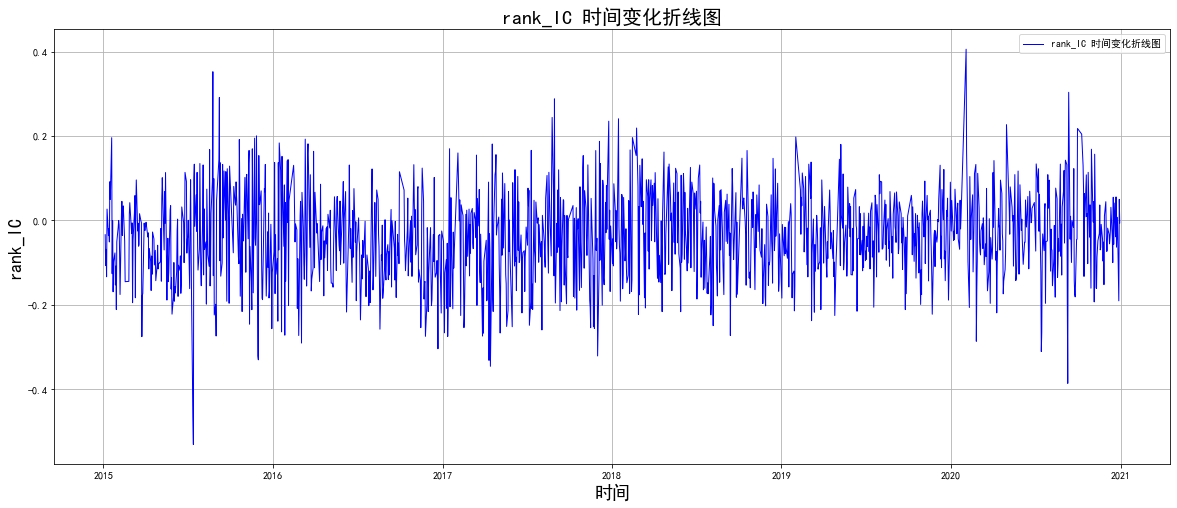

In [35]:


# rank IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_3['trade_date']
y=IC_3['rank_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='rank_IC 时间变化折线图')
plt.title('rank_IC 时间变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('rank_IC',fontsize=18)
plt.legend()
plt.grid()
plt.savefig('rank_IC 时间变化折线图.png')
plt.show()




In [36]:
IC_4=pd.DataFrame()
Normal_IC=pd.Series({"mean":IC_1['Normal_IC'].mean(),"std":IC_1['Normal_IC'].std(),"IRIC":IC_1['Normal_IC'].mean()/IC_1['Normal_IC'].std(),"skew":IC_1['Normal_IC'].skew()},name="Normal_IC")
rank_IC=pd.Series({"mean":IC_3['rank_IC'].mean(),"std":IC_3['rank_IC'].std(),"IRIC":IC_3['rank_IC'].mean()/IC_3['rank_IC'].std(),"skew":IC_3['rank_IC'].skew()},name="rank_IC")
IC_4=IC_4.append(Normal_IC)
IC_4=IC_4.append(rank_IC)


In [37]:
IC_4

,IRIC,mean,skew,std
Normal_IC,-0.350043,-0.045501,0.050600,0.129988
rank_IC,-0.386400,-0.040585,0.001854,0.105034


In [38]:
ret_5

,trade_date,ts_code,ret_t1,industry_name,ind_mean,industry_id,close,turnover_rate,total_share,firm_size,year,win_turnover,ind_neu_turnover,fz_ind_neu_turnover,date_mean,date_std,std_neu_turnover,fac_rank
0,2015-01-05,000001.SZ,-0.014981,银行,2.700550,011018,16.02,2.9079,1.142489e+06,1.830268e+07,2015,2.9079,0.207350,0.354404,6.536872e-17,2.179449,0.162612,1600.0
1,2015-01-05,000002.SZ,-0.036888,房地产,4.421861,011015,14.91,6.7834,1.101503e+06,1.642341e+07,2015,6.7834,2.361539,2.491836,6.536872e-17,2.179449,1.143333,2096.0
2,2015-01-05,000004.SZ,0.049076,医药生物,2.289757,011012,15.69,3.3496,8.397668e+03,1.317594e+05,2015,3.3496,1.059843,1.044877,6.536872e-17,2.179449,0.479422,1848.0
3,2015-01-05,000006.SZ,-0.032486,房地产,4.421861,011015,7.08,8.0562,1.349995e+05,9.557965e+05,2015,8.0562,3.634339,3.626720,6.536872e-17,2.179449,1.664054,2187.0
4,2015-01-05,000007.SZ,-0.017218,休闲服务,3.036586,011017,14.52,1.3807,2.309654e+04,3.353617e+05,2015,1.3807,-1.655886,-1.669036,6.536872e-17,2.179449,-0.765807,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600793,2020-12-31,688699.SH,NaN,电子,2.888955,011006,55.17,11.4489,7.436800e+03,4.102883e+05,2020,11.4489,8.559945,8.525039,-1.669784e-16,2.690855,3.168152,3986.0
4600794,2020-12-31,688777.SH,NaN,电气设备,3.274642,011023,100.20,5.5458,4.912900e+04,4.922726e+06,2020,5.5458,2.271158,2.329173,-1.669784e-16,2.690855,0.865588,3631.0
4600795,2020-12-31,688788.SH,NaN,国防军工,4.908080,011025,133.30,8.1020,7.553423e+03,1.006871e+06,2020,8.1020,3.193920,3.171299,-1.669784e-16,2.690855,1.178547,3742.0
4600796,2020-12-31,688981.SH,NaN,电子,2.888955,011006,57.75,4.5320,7.703506e+05,4.448775e+07,2020,4.5320,1.643045,2.515794,-1.669784e-16,2.690855,0.934942,3665.0


In [39]:
# 分层测试
Group_test=ret_5.copy()
Group_test['Group_ID']=Group_test.groupby(['trade_date'])['std_neu_turnover'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
Group_test_1=pd.DataFrame(Group_test.groupby(['trade_date','Group_ID'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'Group_ret_mean'})


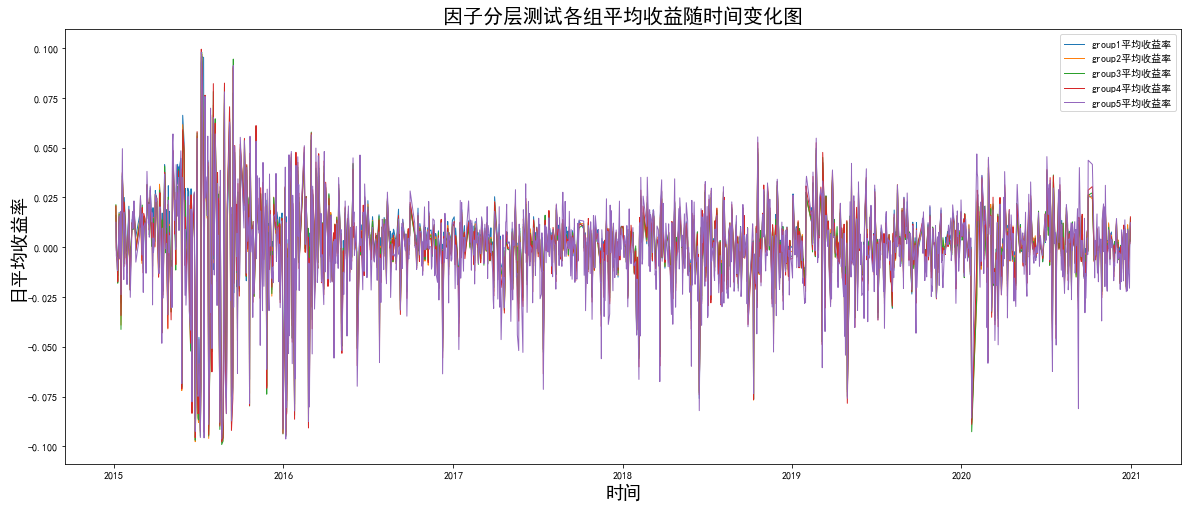

In [40]:
# 因子分层测试各组日平均收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['Group_ret_mean']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['Group_ret_mean']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['Group_ret_mean']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['Group_ret_mean']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['Group_ret_mean']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1平均收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2平均收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3平均收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4平均收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5平均收益率')
plt.title('因子分层测试各组平均收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('日平均收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.savefig('因子分层测试各组平均收益随时间变化图.png')
plt.show()


In [41]:
# 计算各组累计收益率

Group_test_1['cum_rev'] =Group_test_1.sort_values(by=['Group_ID','trade_date']).groupby(['Group_ID'])['Group_ret_mean'].apply(lambda x:(1 + x).cumprod())

In [42]:
Group_test_1.sort_values(by=['Group_ID','trade_date'])

,trade_date,Group_ID,Group_ret_mean,cum_rev
0,2015-01-05,1,0.015984,1.015984
5,2015-01-06,1,0.003412,1.019451
10,2015-01-07,1,-0.001502,1.017920
15,2015-01-08,1,-0.003277,1.014584
20,2015-01-09,1,-0.014304,1.000071
...,...,...,...,...
7289,2020-12-25,5,-0.009884,0.078396
7294,2020-12-28,5,-0.020593,0.076782
7299,2020-12-29,5,0.008909,0.077466
7304,2020-12-30,5,0.012357,0.078423


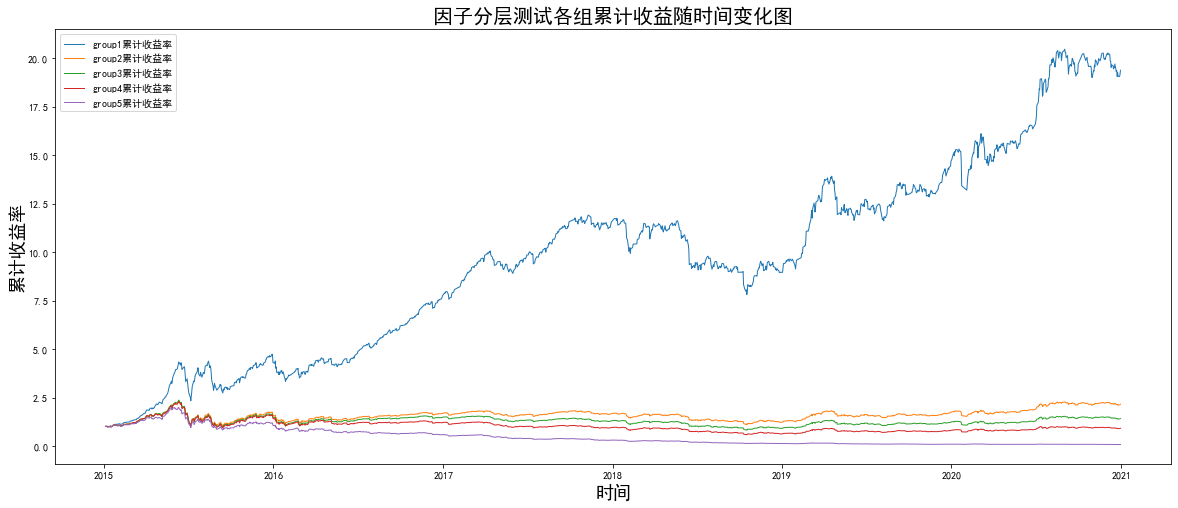

In [43]:

# 计算各组累计收益率

Group_test_1['cum_rev'] =Group_test_1.sort_values(by=['Group_ID','trade_date']).groupby(['Group_ID'])['Group_ret_mean'].apply(lambda x:(1 + x).cumprod())

# 因子分层测试各组累计收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1累计收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2累计收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3累计收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4累计收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5累计收益率')
plt.title('因子分层测试各组累计收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('累计收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.savefig('因子分层测试各组累计收益随时间变化图.png')
plt.show()




In [44]:
# 计算各组年化收益率&年化波动率&夏普比率&最大回撤

Annual_1=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].mean()).reset_index().rename(columns={'Group_ret_mean':'aver_ret'})
Annual_2=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].var()).reset_index().rename(columns={'Group_ret_mean':'volatility'})
Annual_3=pd.merge(Annual_1,Annual_2,on=['Group_ID'])
Annual_3['Annual_aver_ret']=(1+Annual_3['aver_ret'])**252-1
Annual_3['Annual_vol']=((Annual_3['volatility'])*252)**0.5
Annual_3['Annual_Sharpe']=252*Annual_3['aver_ret']/Annual_3['Annual_vol']

arr_1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
j_1 = np.argmax((np.maximum.accumulate(arr_1) - arr_1)/np.maximum.accumulate(arr_1)) # end of the period
i_1 = np.argmax(arr_1[:j_1]) # start of period
MaxDrawdown_1=(1-arr_1.iloc[j_1]/arr_1.iloc[i_1])

arr_2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
j_2 = np.argmax((np.maximum.accumulate(arr_2) - arr_2)/np.maximum.accumulate(arr_2)) # end of the period
i_2 = np.argmax(arr_2[:j_2]) # start of period
MaxDrawdown_2=(1-arr_2.iloc[j_2]/arr_2.iloc[i_2])


arr_3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
j_3 = np.argmax((np.maximum.accumulate(arr_3) - arr_3)/np.maximum.accumulate(arr_3)) # end of the period
i_3 = np.argmax(arr_3[:j_3]) # start of period
MaxDrawdown_3=(1-arr_3.iloc[j_3]/arr_3.iloc[i_3])


arr_4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
j_4 = np.argmax((np.maximum.accumulate(arr_4) - arr_4)/np.maximum.accumulate(arr_4)) # end of the period
i_4 = np.argmax(arr_4[:j_4]) # start of period
MaxDrawdown_4=(1-arr_4.iloc[j_4]/arr_4.iloc[i_4])


arr_5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']
j_5 = np.argmax((np.maximum.accumulate(arr_5) - arr_5)/np.maximum.accumulate(arr_5)) # end of the period
i_5 = np.argmax(arr_5[:j_5]) # start of period
MaxDrawdown_5=(1-arr_5.iloc[j_5]/arr_5.iloc[i_5])




Annual_4=pd.DataFrame()
Annual_aver_ret=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_aver_ret']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_aver_ret']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_aver_ret']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_aver_ret']),"Group5":float(Annual_3[Annual_3['Group_ID']=='5']['Annual_aver_ret'])},name="Annual_average_return")
Annual_vol=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_vol']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_vol']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_vol']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol'])},name="Annual_volatility")
Annual_sharpe=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_Sharpe']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_Sharpe']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_Sharpe']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe'])},name="Annual_Sharpe_Ratio")
Annual_MaxDrawdown=pd.Series({"Group1":MaxDrawdown_1,"Group2":MaxDrawdown_2,"Group3":MaxDrawdown_3,"Group4":MaxDrawdown_4,"Group5":MaxDrawdown_5},name="Annual_MaxDrawdown")


Annual_4=Annual_4.append(Annual_aver_ret)
Annual_4=Annual_4.append(Annual_vol)
Annual_4=Annual_4.append(Annual_sharpe)
Annual_4=Annual_4.append(Annual_MaxDrawdown)


In [45]:
Annual_4.T.reset_index()

,index,Annual_average_return,Annual_volatility,Annual_Sharpe_Ratio,Annual_MaxDrawdown
0,Group1,0.747717,0.305694,1.828394,0.461910
1,Group2,0.203164,0.321102,0.576212,0.557296
2,Group3,0.123993,0.332659,0.351456,0.655692
3,Group4,0.047344,0.347906,0.132973,0.747882
4,Group5,-0.307177,0.332659,0.351456,0.961695


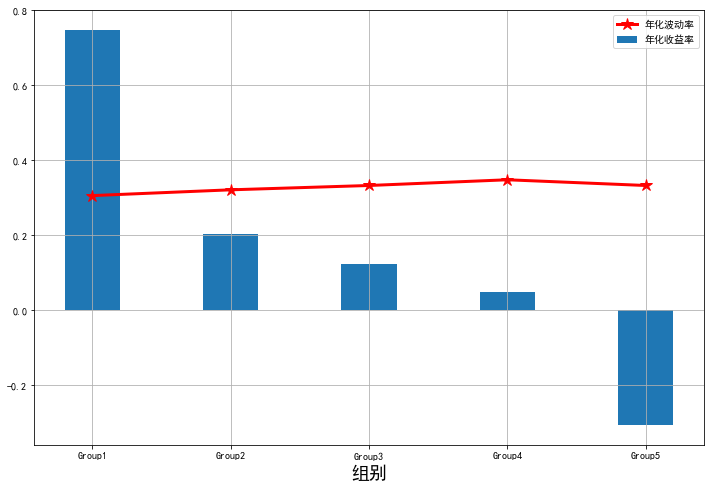

In [46]:
# 年化数据组合图：年化收益&年化波动率
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y1=Annual_5['Annual_average_return']
y2=Annual_5['Annual_volatility']
# y3=Annual_5['Annual_Sharpe_Ratio']
# y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.bar(x,y1,width=0.4,label='年化收益率')
plt.plot(x,y2,lw=3,ms=13,color='red',marker='*',label='年化波动率')
# plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
# plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.savefig('年化数据组合图：年化收益&年化波动率.png')
plt.show()


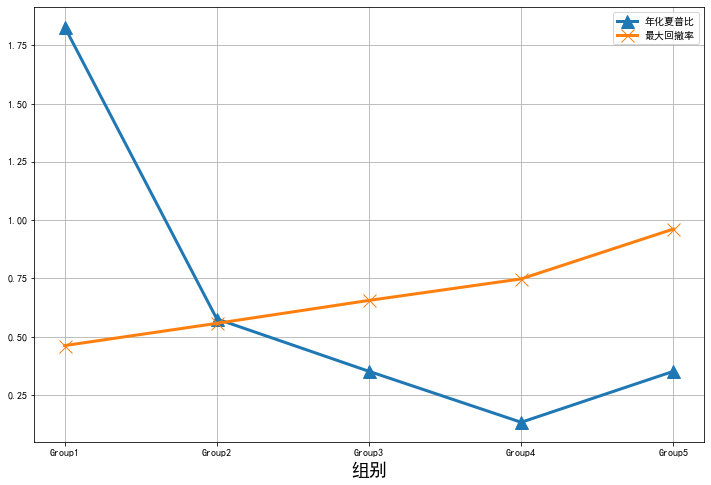

In [47]:
# 年化数据组合图：最大回撤&年化夏普
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y3=Annual_5['Annual_Sharpe_Ratio']
y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.savefig('年化数据组合图：最大回撤&年化夏普.png')
plt.show()


In [48]:
#各行业group1的年化收益

Ind_Group_test=Group_test[Group_test['Group_ID']=='1']
Ind_Group_test_1=pd.DataFrame(Ind_Group_test.groupby(['industry_name'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'ind_aver_ret'})
Ind_Group_test_1['Annual_ret']=(1+Ind_Group_test_1['ind_aver_ret'])**252-1

In [49]:
Ind_Group_test_1

,industry_name,ind_aver_ret,Annual_ret
0,交通运输,0.001663,0.520188
1,休闲服务,0.004090,1.797394
2,传媒,0.001946,0.632261
3,公用事业,-0.000274,-0.066835
4,农林牧渔,0.001350,0.404927
5,化工,0.001683,0.527780
6,医药生物,0.002913,1.081476
7,商业贸易,0.003568,1.453813
8,国防军工,0.002271,0.771205
9,家用电器,0.002017,0.661457


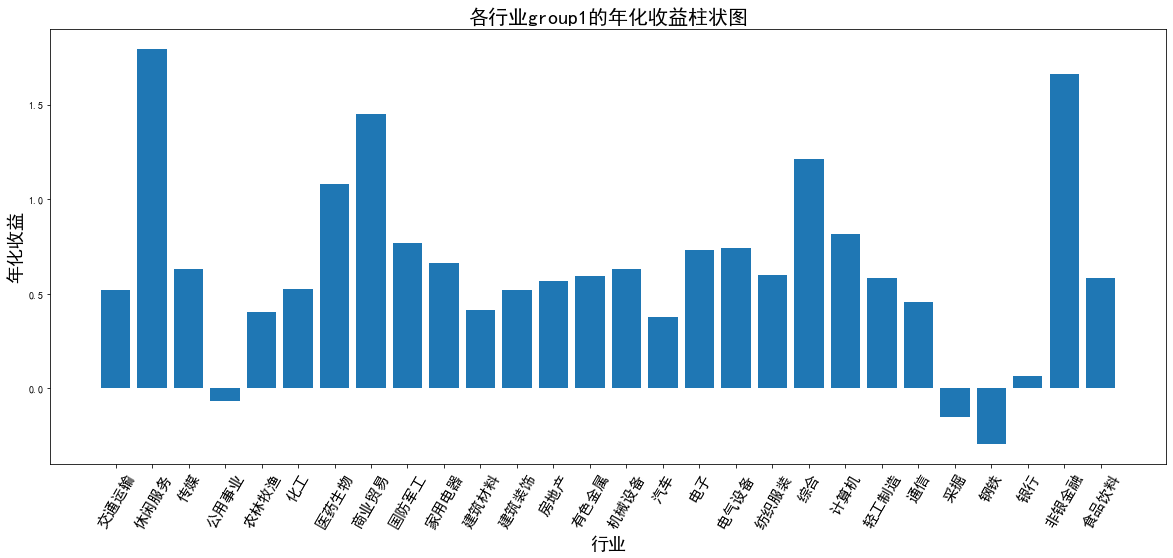

In [50]:
####各行业group1的年化收益 

plt.figure(figsize=(20,8))
x=Ind_Group_test_1['industry_name']
y=Ind_Group_test_1['Annual_ret']
plt.bar(x,y)
plt.title('各行业group1的年化收益柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('年化收益',fontsize=18)
# plt.grid()
plt.savefig('各行业group1的年化收益柱状图.png')
plt.show()


In [51]:
# 各个组别的换手率测试

Turnover_test_1=Group_test[Group_test['Group_ID']=='1']
turnover_1 = pd.DataFrame()
turnover_1['trade_date']= Turnover_test_1.trade_date.unique()
turnover_1['turnover'] = 0
    
for i in range(1,turnover_1.shape[0]):
    stock_now = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_1.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    

    

In [52]:
turnover_1

,trade_date,turnover
0,2015-01-05,0.000000
1,2015-01-06,0.294872
2,2015-01-07,0.305556
3,2015-01-08,0.264392
4,2015-01-09,0.275641
...,...,...
1457,2020-12-25,0.231425
1458,2020-12-28,0.219245
1459,2020-12-29,0.197080
1460,2020-12-30,0.189550


In [78]:
y_range

[0.0, 0.2, 0.4, 0.6, 0.8]

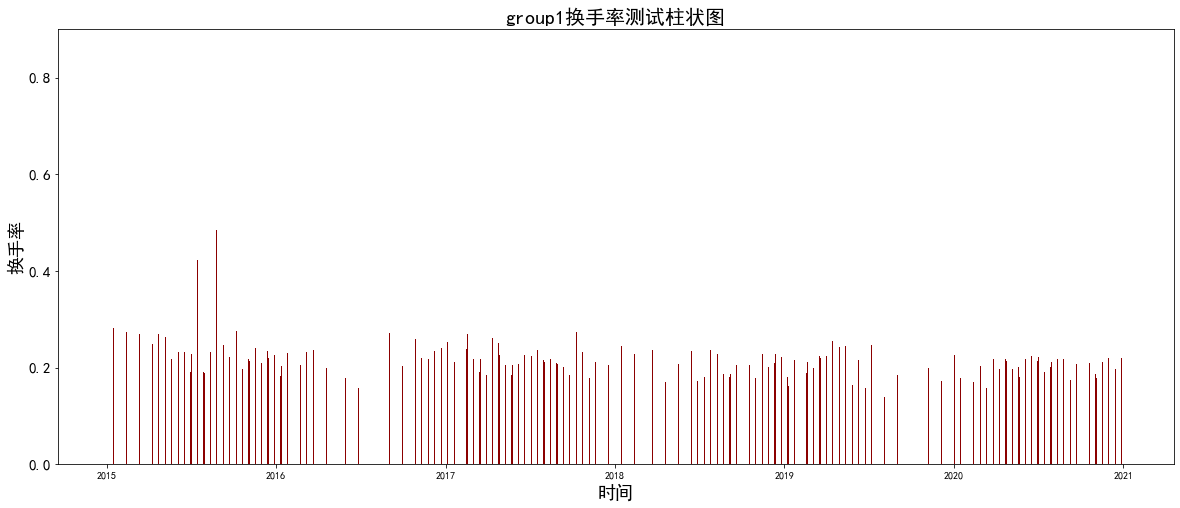

In [79]:
####group1换手率测试柱状图

plt.figure(figsize=(20,8))
x=turnover_1['trade_date']
y=turnover_1['turnover']

x_year=pd.Series(turnover_1['trade_date'].dt.year.unique())
y_range=[0.0,0.2,0.4,0.6,0.8]

plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('group1换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x_year,fontsize=15)
plt.yticks(y_range,fontsize=15)
plt.ylim(0,0.9,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('group1换手率测试柱状图.png')
plt.show()



In [80]:
# 各个组别的换手率测试

Turnover_test_2=Group_test[Group_test['Group_ID']=='2']
turnover_2 = pd.DataFrame()
turnover_2['trade_date']= Turnover_test_2.trade_date.unique()
turnover_2['turnover'] = 0
    
for i in range(1,turnover_2.shape[0]):
    stock_now = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_2.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


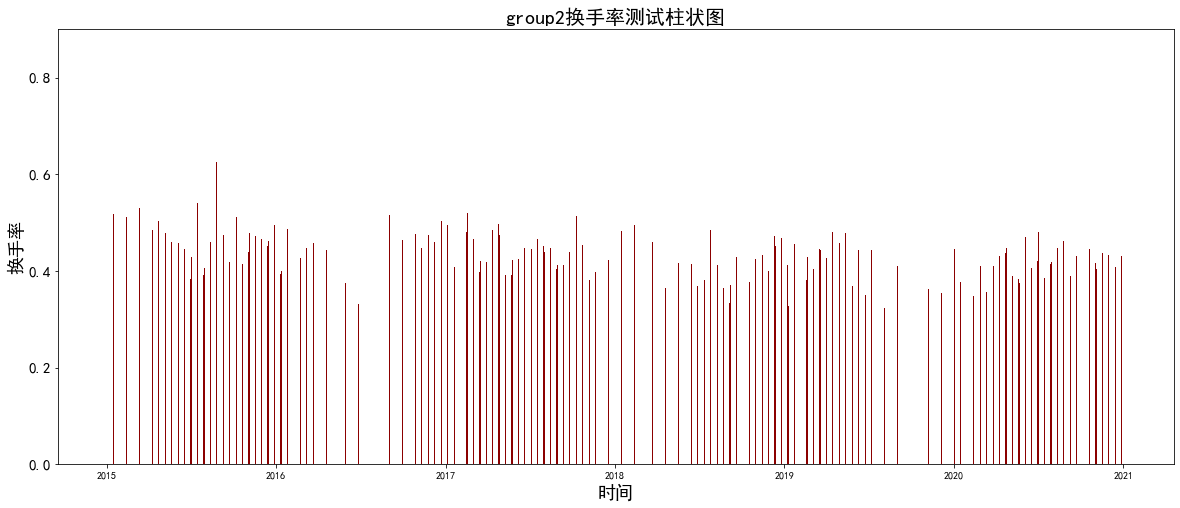

In [82]:
####group2换手率测试柱状图

plt.figure(figsize=(20,8))
x=turnover_2['trade_date']
y=turnover_2['turnover']

y_range=[0.0,0.2,0.4,0.6,0.8]

plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('group2换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
plt.yticks(y_range,fontsize=15)
plt.ylim(0,0.9,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('group2换手率测试柱状图.png')
plt.show()


In [56]:
# 各个组别的换手率测试

Turnover_test_3=Group_test[Group_test['Group_ID']=='3']
turnover_3 = pd.DataFrame()
turnover_3['trade_date']= Turnover_test_3.trade_date.unique()
turnover_3['turnover'] = 0
    
for i in range(1,turnover_3.shape[0]):
    stock_now = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_3.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


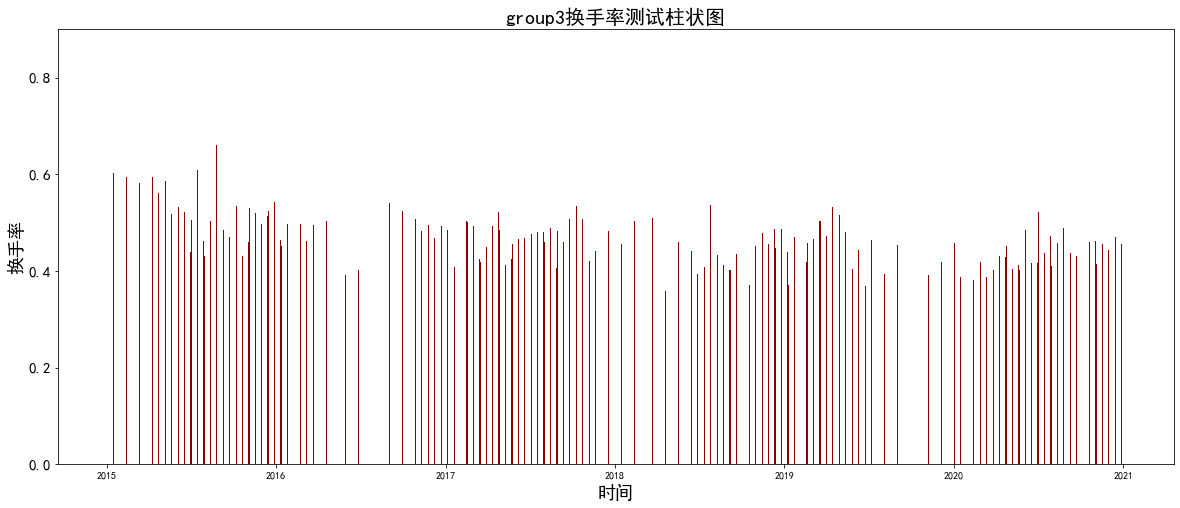

In [83]:
####group3换手率测试柱状图

plt.figure(figsize=(20,8))
x=turnover_3['trade_date']
y=turnover_3['turnover']

y_range=[0.0,0.2,0.4,0.6,0.8]

plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('group3换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
plt.yticks(y_range,fontsize=15)
plt.ylim(0,0.9,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('group3换手率测试柱状图.png')
plt.show()


In [84]:
# 各个组别的换手率测试

Turnover_test_4=Group_test[Group_test['Group_ID']=='4']
turnover_4 = pd.DataFrame()
turnover_4['trade_date']= Turnover_test_4.trade_date.unique()
turnover_4['turnover'] = 0
    
for i in range(1,turnover_4.shape[0]):
    stock_now = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_4.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


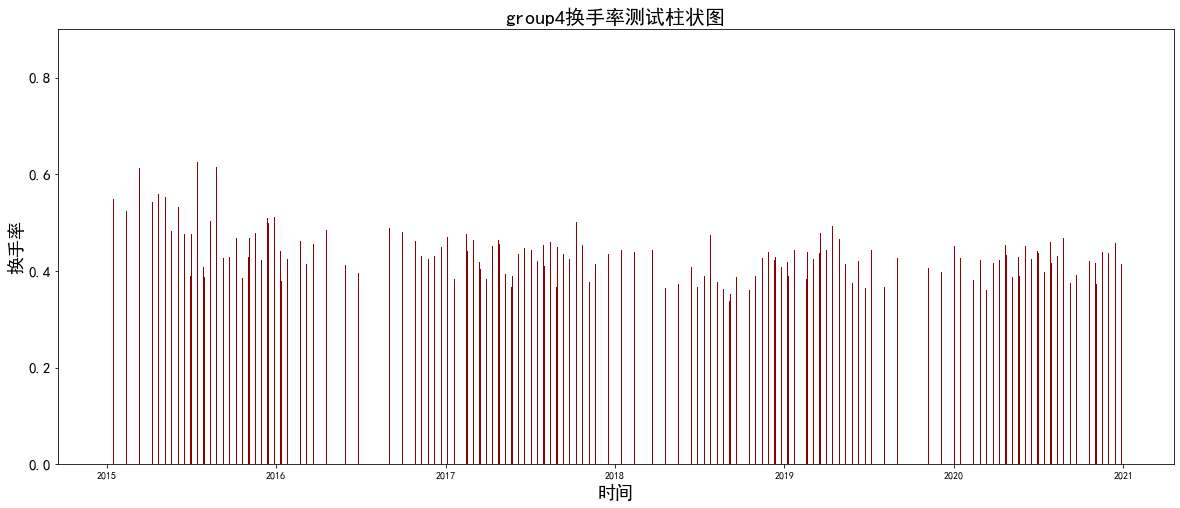

In [87]:
####group4换手率测试柱状图

plt.figure(figsize=(20,8))
x=turnover_4['trade_date']
y=turnover_4['turnover']

y_range=[0.0,0.2,0.4,0.6,0.8]


plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('group4换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
plt.yticks(y_range,fontsize=15)
plt.ylim(0,0.9,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('group4换手率测试柱状图.png')
plt.show()


In [88]:
# 各个组别的换手率测试

Turnover_test_5=Group_test[Group_test['Group_ID']=='5']
turnover_5 = pd.DataFrame()
turnover_5['trade_date']= Turnover_test_5.trade_date.unique()
turnover_5['turnover'] = 0
    
for i in range(1,turnover_5.shape[0]):
    stock_now = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_5.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


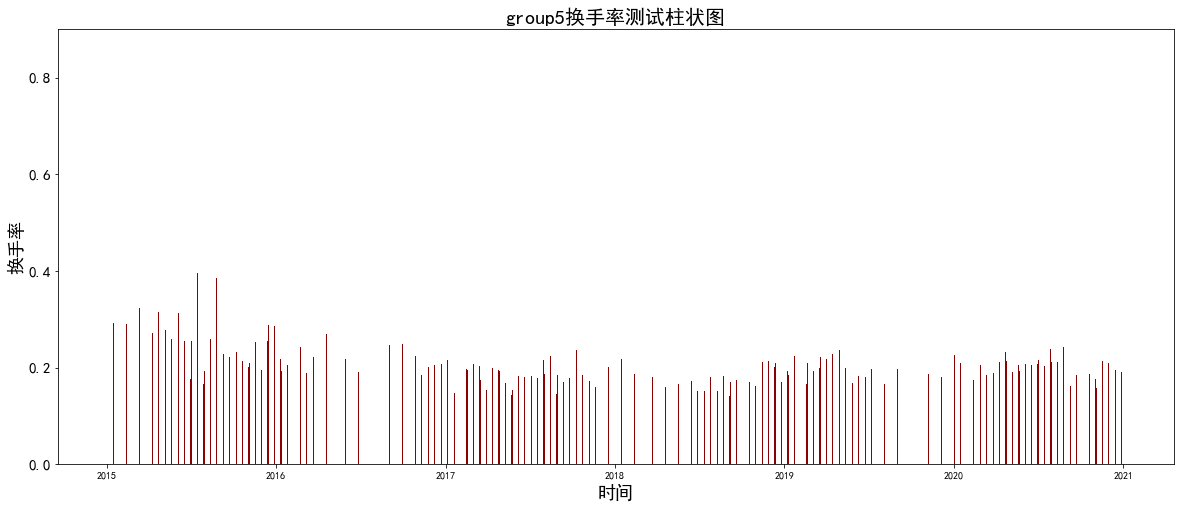

In [90]:
####group5换手率测试柱状图

plt.figure(figsize=(20,8))
x=turnover_5['trade_date']
y=turnover_5['turnover']


y_range=[0.0,0.2,0.4,0.6,0.8]

plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('group5换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
plt.yticks(y_range,fontsize=15)
plt.ylim(0,0.9,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.savefig('group5换手率测试柱状图.png')
plt.show()


In [62]:
ret_5

,trade_date,ts_code,ret_t1,industry_name,ind_mean,industry_id,close,turnover_rate,total_share,firm_size,year,win_turnover,ind_neu_turnover,fz_ind_neu_turnover,date_mean,date_std,std_neu_turnover,fac_rank
0,2015-01-05,000001.SZ,-0.014981,银行,2.700550,011018,16.02,2.9079,1.142489e+06,1.830268e+07,2015,2.9079,0.207350,0.354404,6.536872e-17,2.179449,0.162612,1600.0
1,2015-01-05,000002.SZ,-0.036888,房地产,4.421861,011015,14.91,6.7834,1.101503e+06,1.642341e+07,2015,6.7834,2.361539,2.491836,6.536872e-17,2.179449,1.143333,2096.0
2,2015-01-05,000004.SZ,0.049076,医药生物,2.289757,011012,15.69,3.3496,8.397668e+03,1.317594e+05,2015,3.3496,1.059843,1.044877,6.536872e-17,2.179449,0.479422,1848.0
3,2015-01-05,000006.SZ,-0.032486,房地产,4.421861,011015,7.08,8.0562,1.349995e+05,9.557965e+05,2015,8.0562,3.634339,3.626720,6.536872e-17,2.179449,1.664054,2187.0
4,2015-01-05,000007.SZ,-0.017218,休闲服务,3.036586,011017,14.52,1.3807,2.309654e+04,3.353617e+05,2015,1.3807,-1.655886,-1.669036,6.536872e-17,2.179449,-0.765807,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600793,2020-12-31,688699.SH,NaN,电子,2.888955,011006,55.17,11.4489,7.436800e+03,4.102883e+05,2020,11.4489,8.559945,8.525039,-1.669784e-16,2.690855,3.168152,3986.0
4600794,2020-12-31,688777.SH,NaN,电气设备,3.274642,011023,100.20,5.5458,4.912900e+04,4.922726e+06,2020,5.5458,2.271158,2.329173,-1.669784e-16,2.690855,0.865588,3631.0
4600795,2020-12-31,688788.SH,NaN,国防军工,4.908080,011025,133.30,8.1020,7.553423e+03,1.006871e+06,2020,8.1020,3.193920,3.171299,-1.669784e-16,2.690855,1.178547,3742.0
4600796,2020-12-31,688981.SH,NaN,电子,2.888955,011006,57.75,4.5320,7.703506e+05,4.448775e+07,2020,4.5320,1.643045,2.515794,-1.669784e-16,2.690855,0.934942,3665.0


xtick = np.arange(0,turnover_1.shape[0],12)
xticklabel = pd.Series(turnover_1.index[xtick])  
        
plt.figure(figsize = (8,4))
ax = plt.axes()
    
plt.bar(np.arange(turnover.shape[0]),turnover.turnover,color = 'darkred',width = 0.2)       
ax.set_xticks(xtick)
ax.set_xticklabels(xticklabel) 
plt.title('组合换手率',fontsize = 15)

Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D,20D
Ann. alpha,-0.392,-0.330,-0.274,-0.216
beta,0.086,0.076,0.069,0.062
Mean Period Wise Return Top Quantile (bps),-18.768,-15.044,-12.241,-9.584
Mean Period Wise Return Bottom Quantile (bps),17.925,14.773,11.713,8.061
Mean Period Wise Spread (bps),-36.693,-29.884,-24.007,-17.676


<Figure size 432x288 with 0 Axes>

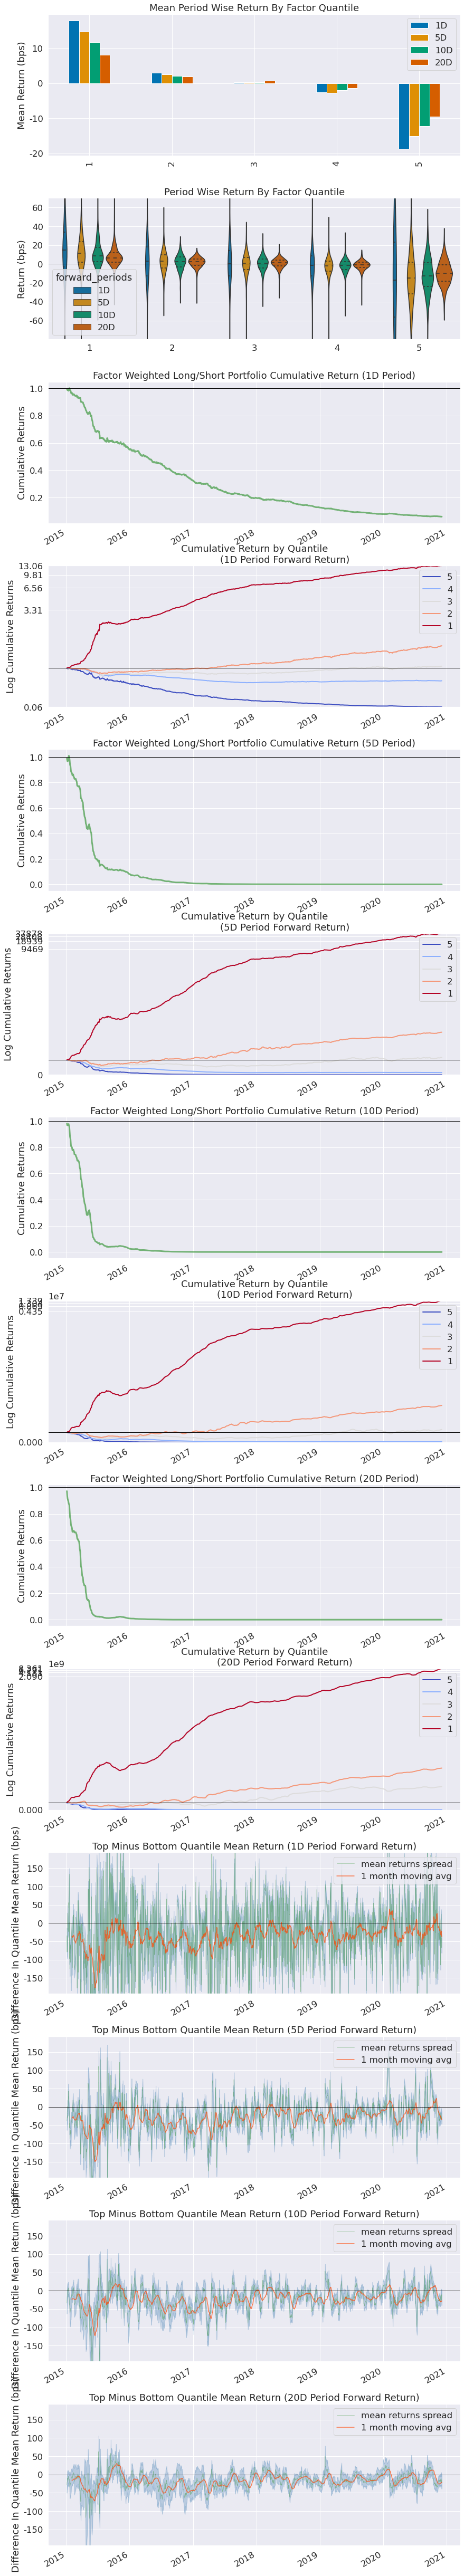

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [63]:
# Alphalens 回测结果

final=ret_5.set_index(["trade_date","ts_code"])
factor_init = final["std_neu_turnover"].copy()
price_df = final["close"].unstack().copy()
factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,quantiles=5, bins=None,periods=(1,5,10,20),max_loss=1)


factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,groupby=None,binning_by_group=False,quantiles=5,bins=None,periods=(1,5,10,20),filter_zscore=20,groupby_labels=None,max_loss=1,zero_aware=False,cumulative_returns=True)
al.tears.create_returns_tear_sheet(factor)
al.tears.create_information_tear_sheet(factor, group_neutral=False,by_group=False)
al.tears.create_turnover_tear_sheet(factor, turnover_periods=None)
